In [85]:
%%capture

from qiskit import IBMQ
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

IBMQ.load_accounts()

In [111]:
# Create our initial registers for the Bernstein-Vazirani Algorithm
q = QuantumRegister(4, name='q')
tmp = QuantumRegister(1, name='t')
meas = ClassicalRegister(4, name='m')

In [112]:
# Create the Oracle
# We'll choose the secret bitstring 14 == 1110

oracle = QuantumCircuit(q, tmp, meas, name='Oracle')
s = 14

for i in range(len(q)):
    if s & (1 << i):
        oracle.cx(q[i], tmp[0])


In [113]:
print(oracle.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
qreg t[1];
creg m[4];
cx q[1],t[0];
cx q[2],t[0];
cx q[3],t[0];



In [114]:
# Now we create the Bernstein_Vazirani circuit
bv = QuantumCircuit(q, tmp, meas)
bv.x(tmp[0])

# If we don't provide an index, then the h applies to the entire register
bv.h(q)
bv.h(tmp)

# We'll come back to this
bv += oracle

# Second layer of hadamards
bv.h(q)
bv.h(tmp)

bv.measure(q, meas)

In [115]:
print(bv.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
qreg t[1];
creg m[4];
x t[0];
h q[0];
h q[1];
h q[2];
h q[3];
h t[0];
cx q[1],t[0];
cx q[2],t[0];
cx q[3],t[0];
h q[0];
h q[1];
h q[2];
h q[3];
h t[0];
measure q[0] -> m[0];
measure q[1] -> m[1];
measure q[2] -> m[2];
measure q[3] -> m[3];



In [116]:
# Show text circuit
bv.draw()

<pre style="word-wrap: normal;white-space: pre;line-height: 15px;">        ┌───┐┌───┐     ┌─┐                             
q_0: |0>┤ H ├┤ H ├─────┤M├─────────────────────────────
        ├───┤└───┘     └╥┘┌───┐     ┌─┐                
q_1: |0>┤ H ├───────■───╫─┤ H ├─────┤M├────────────────
        ├───┤       │   ║ └───┘     └╥┘┌───┐┌─┐        
q_2: |0>┤ H ├───────┼───╫───■────────╫─┤ H ├┤M├────────
        ├───┤       │   ║   │        ║ └───┘└╥┘┌───┐┌─┐
q_3: |0>┤ H ├───────┼───╫───┼────■───╫───────╫─┤ H ├┤M├
        ├───┤┌───┐┌─┴─┐ ║ ┌─┴─┐┌─┴─┐ ║       ║ ├───┤└╥┘
t_0: |0>┤ X ├┤ H ├┤ X ├─╫─┤ X ├┤ X ├─╫───────╫─┤ H ├─╫─
        └───┘└───┘└───┘ ║ └───┘└───┘ ║       ║ └───┘ ║ 
 m_0: 0 ════════════════╩════════════╬═══════╬═══════╬═
                                     ║       ║       ║ 
 m_1: 0 ═════════════════════════════╩═══════╬═══════╬═
                                             ║       ║ 
 m_2: 0 ═════════════════════════════════════╩═══════╬═
                                                     ║ 
 m_3: 0 ═════════════════════════════════════════════╩═
                                                       </pre>

In [117]:
# Show matplotlib figure
# Just calling bv.draw(output='mpl') works in browsers

import matplotlib.pyplot as plt
fig = bv.draw(output='mpl')
fig.show()

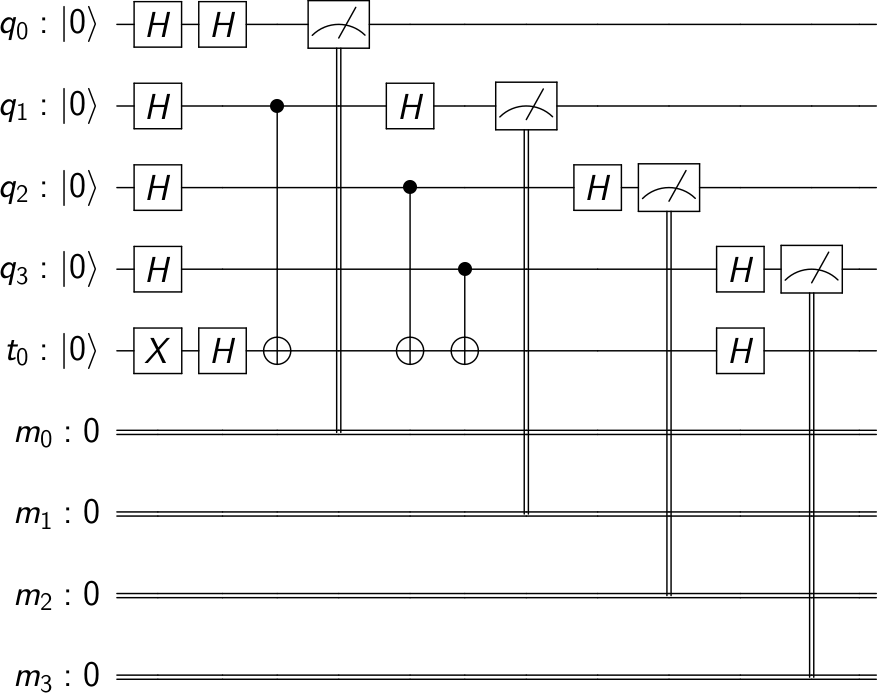

In [118]:
# Show Latex figure
bv.draw(output='latex')

In [109]:
# Show latex figure source
# bv.draw(output='latex_source')

In [119]:
# Now let's clean up our circuit by using barriers
circ = QuantumCircuit(q, tmp, meas)

circ.x(tmp[0])
circ.barrier()

circ.h(q)
circ.h(tmp)
circ.barrier()

circ += oracle
circ.barrier()

circ.h(q)
circ.h(tmp)
circ.barrier()

circ.measure(q, meas)

In [120]:
fig = circ.draw(output='mpl')
fig.show()

In [41]:
# Even better cleanup
fig2 = circ.draw(output='mpl', plot_barriers=False)
fig2.show()

In [99]:
# Now let's go back to how our circuit is defined.  
# Maybe we want to improve our abstraction

abstract_circ = QuantumCircuit(q, tmp, meas)
abstract_circ.x(tmp[0])
abstract_circ.barrier()

abstract_circ.h(q)
abstract_circ.h(tmp)
abstract_circ.barrier()

# Instead of showing our individual gates, we just want an abstract gate
gate_oracle = oracle.to_instruction()

# Note that to append, we have to create lists from our registers
abstract_circ.append(gate_oracle,
                     [q[0], q[1], q[2], q[3], tmp[0]],
                     list(meas))
abstract_circ.barrier()

abstract_circ.h(q)
abstract_circ.h(tmp)
abstract_circ.barrier()

abstract_circ.measure(q, meas)


In [100]:
fig3 = abstract_circ.draw(output='mpl', plot_barriers=False)
fig3.show()

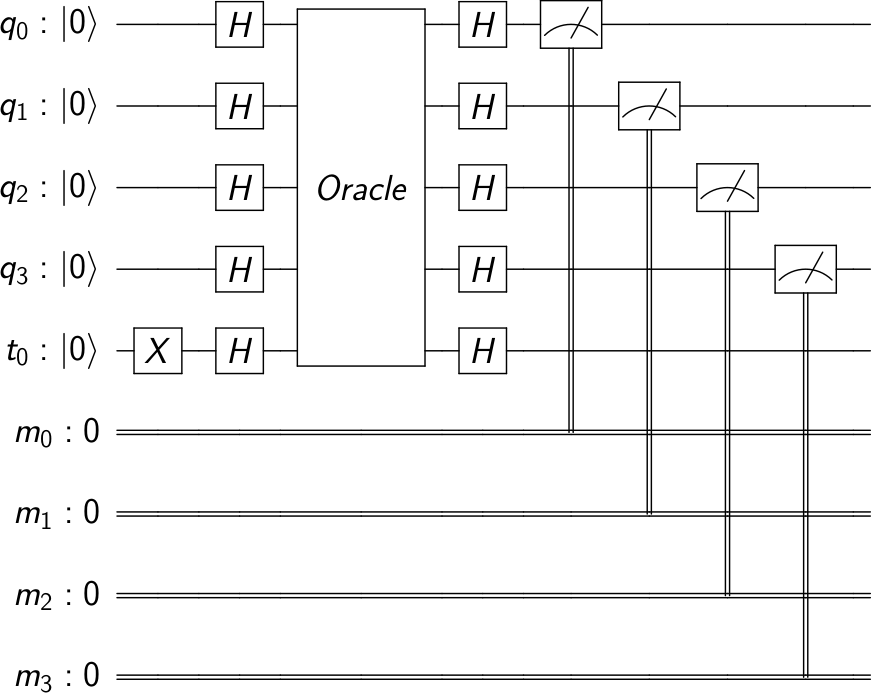

In [101]:
abstract_circ.draw(output='latex', plot_barriers=False)

In [121]:
# # Finally, we can recover our original view by way of "decompose"
# 
# decomposed_circ = abstract_circ.decompose()
# fig4 = decomposed_circ.draw(output='mpl', plot_barriers=False)
# fig4.show()

In [93]:
# Now we run our circuit
# First, we need to know our backends

from qiskit import Aer, BasicAer,execute # Local backends, sim only

# We've already imported the IBMQ module that gives access to remote backends -- both real and sims. 

# Now let's look at them
for idx, be in enumerate(IBMQ.backends()):
    print(f'IBMQ backend {idx}: {be}')

for idx, be in enumerate(Aer.backends()):
    print(f'Aer (sim) backend {idx}: {be}')
    
for idx, be in enumerate(BasicAer.backends()):
    print(f'Aer (sim) backend {idx}: {be}')

IBMQ backend 0: ibmqx4
IBMQ backend 1: ibmqx2
IBMQ backend 2: ibmq_16_melbourne
IBMQ backend 3: ibmq_qasm_simulator
Aer (sim) backend 0: qasm_simulator
Aer (sim) backend 1: statevector_simulator
Aer (sim) backend 2: unitary_simulator
Aer (sim) backend 0: qasm_simulator
Aer (sim) backend 1: statevector_simulator
Aer (sim) backend 2: unitary_simulator


In [122]:
# We select a backend
backend = BasicAer.get_backend(name='qasm_simulator')

# Now we execute
result = execute(circ, backend).result()
counts = result.get_counts(circ)

In [123]:
# Now we can visualize and explore

print(counts)

{'1110': 1024}


In [125]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts, title='Secret Bitstring Results').show()

In [127]:
# That's a bit boring though.  Lets do a bell state circuit

qr = QuantumRegister(2)
msr = ClassicalRegister(2)

bs = QuantumCircuit(qr, msr)
bs.h(qr[0])
bs.cx(qr[0], qr[1])
bs.measure(qr, msr)

result = execute(bs, backend).result()
counts = result.get_counts(bs)

print(counts)
plot_histogram(counts, title='Bell State Experiment').show()



{'11': 518, '00': 506}
